In [2]:
import os as os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate, reg_lambda):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.reg_lambda = reg_lambda

        # Initialize weights and biases
        self.W1 = np.random.randn(self.input_size, self.hidden_size) * 0.01
        self.b1 = np.zeros((1, self.hidden_size))
        self.W2 = np.random.randn(self.hidden_size, self.output_size) * 0.01
        self.b2 = np.zeros((1, self.output_size))

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        return z * (1 - z)

    def softmax(self, z):
        exp_scores = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def forward_propagation(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2

    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        logprobs = -np.log(y_pred[range(m), y_true])
        data_loss = np.sum(logprobs) / m

        # Add regularization term to loss
        data_loss += (self.reg_lambda / 2) * (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)))
        return data_loss

    def backward_propagation(self, X, y_true, y_pred):
        m = X.shape[0]

        delta3 = y_pred
        delta3[range(m), y_true] -= 1
        dW2 = (np.dot(self.a1.T, delta3) + self.reg_lambda * self.W2) / m
        db2 = np.sum(delta3, axis=0, keepdims=True) / m

        delta2 = np.dot(delta3, self.W2.T) * self.sigmoid_derivative(self.a1)
        dW1 = (np.dot(X.T, delta2) + self.reg_lambda * self.W1) / m
        db1 = np.sum(delta2, axis=0) / m

        # Update weights and biases using gradient descent
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    def train(self, X_train, y_train, epochs=500):
        loss_history = []
        for epoch in range(epochs):
            y_pred = self.forward_propagation(X_train)
            loss = self.compute_loss(y_train, y_pred)
            loss_history.append(loss)
            if epoch % 50 == 0:
                print(f'Epoch {epoch}, Loss: {loss}')
            self.backward_propagation(X_train, y_train, y_pred)
        
        return loss_history

    def predict(self, X):
        y_pred = self.forward_propagation(X)
        return np.argmax(y_pred, axis=1)

In [4]:
# for loading the dataset
def load_data(data_dir):
    X = []
    y = []
    class_names = os.listdir(data_dir)
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            image = Image.open(file_path).convert('L')
            image = image.resize((28, 28))
            image_array = np.array(image).flatten()  
            X.append(image_array)
            y.append(label)
    return np.array(X), np.array(y), class_names

In [5]:
# for splitting the dataset into training and validation sets
def train_test_split(X, y, test_size=0.2):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    split_idx = int(X.shape[0] * (1 - test_size))
    X_train, X_test = X[indices[:split_idx]], X[indices[split_idx:]]
    y_train, y_test = y[indices[:split_idx]], y[indices[split_idx:]]
    return X_train, X_test, y_train, y_test

In [6]:
X_train_full, y_train_full, class_names = load_data('/home/asavari/Downloads/Train')

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full)

# initialization and training of nn
input_size = 28 * 28
hidden_size = 128
output_size = len(class_names)
learning_rate = 0.01
reg_lambda = 0.01

/tmp/ipykernel_4627/2737512052.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image_array = np.array(image).flatten()


In [7]:
nn = NeuralNetwork(input_size=input_size,
                   hidden_size=hidden_size,
                   output_size=output_size,
                   learning_rate=learning_rate,
                   reg_lambda=reg_lambda)

loss=nn.train(X_train, y_train)

Epoch 0, Loss: 1.655530338333934
Epoch 50, Loss: 1.247794905051732
Epoch 100, Loss: 0.876330531717908
Epoch 150, Loss: 0.6595849436793564
Epoch 200, Loss: 0.5257913881755245
Epoch 250, Loss: 0.45293661189098483
Epoch 300, Loss: 0.3921682750180222
Epoch 350, Loss: 0.3348272366116413
Epoch 400, Loss: 0.36320465159549586
Epoch 450, Loss: 0.27986409567360837


In [8]:
y_val_pred = nn.predict(X_val)
accuracy_val = np.mean(y_val_pred == y_val)
print(f'Validation Accuracy: {accuracy_val*100}%')

Validation Accuracy: 93.75%


In [9]:
X_test_full, y_test_full, _ = load_data('/home/asavari/Downloads/Test')

/tmp/ipykernel_4627/2737512052.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  image_array = np.array(image).flatten()


In [10]:
y_test_pred = nn.predict(X_test_full)
accuracy_pred = np.mean(y_test_pred == y_test_full)
print(f'Test Accuracy: {accuracy_pred*100:.2f}%')

Test Accuracy: 93.90%


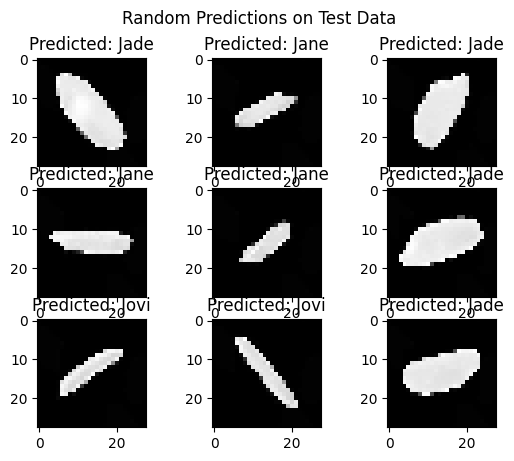

In [11]:
# plotting random predictions on test data
fig, axes = plt.subplots(3, 3)
fig.suptitle('Random Predictions on Test Data')
random_indices = np.random.choice(len(X_test_full), size=9, replace=False)
for i in range(3):
    for j in range(3):
        idx = random_indices[i * 3 + j]
        axes[i][j].imshow(X_test_full[idx].reshape(28, 28), cmap='gray')
        axes[i][j].set_title(f'Predicted: {class_names[y_test_pred[idx]]}')
plt.show()